# **Vision Transformer**
### Sebastián Novoa Acevedo

### **Referencias**
- https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb#scrollTo=TSAVpYtP5VaE

### Configuraciones

### **Se debe cambiar el entorno de ejecución para acelerar por hardware a la opción de TPU**

In [ ]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 49 (delta 6), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (49/49), done.
Already up to date.


In [ ]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 92 kB 881 kB/s 
     |████████████████████████████████| 185 kB 38.4 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 214.4 MB 18 kB/s 
     |████████████████████████████████| 5.9 MB 39.4 MB/s 
     |████████████████████████████████| 349 kB 55.6 MB/s 
     |████████████████████████████████| 237 kB 66.4 MB/s 
     |████████████████████████████████| 145 kB 69.5 MB/s 
     |████████████████████████████████| 438 kB 55.1 MB/s 
     |████████████████████████████████| 1.7 MB 49.4 MB/s 
     |████████████████████████████████| 5.9 MB 51.3 MB/s 
     |████████████████████████████████| 578.0 MB 12 kB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 


### Importamos modelos pre-entrenados

In [ ]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

### Descargamos un modelo pre-entrenado (en este caso ViT-B_32)

In [ ]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
\ [1 files][400.0 MiB/400.0 MiB]                                                
Operation completed over 1 objects/400.0 MiB.                                    


### Importamos archivos

In [ ]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Connected to TPU.


In [ ]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

INFO:absl:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
INFO:absl:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:absl:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
# from google.colab import files
# files.view('vision_transformer/vit_jax/configs/common.py')
# files.view('vision_transformer/vit_jax/configs/models.py')
# files.view('vision_transformer/vit_jax/checkpoint.py')
# files.view('vision_transformer/vit_jax/input_pipeline.py')
# files.view('vision_transformer/vit_jax/models.py')
# files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

### Etiquetas para las imágenes a procesar

In [ ]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Cargamos el dataset (cifar10)

In [ ]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
config.batch = batch_size
config.pp.crop = 224

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmp4yglrcevtfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.


### Definimos Train y Test, para el entrenamiento y evaluación del modelo

In [ ]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')

del config  # Only needed to instantiate datasets.

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpotsjyqqatfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (~/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.08e0b07c81ab4dbc992aa906ef2b4372...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteQE8DFY/cifar10-train.tfrecord*...:   0%|          | 0/…

INFO:absl:Done writing ~/tensorflow_datasets/cifar10/3.0.2.incompleteQE8DFY/cifar10-train.tfrecord*. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteQE8DFY/cifar10-test.tfrecord*...:   0%|          | 0/1…

INFO:absl:Done writing ~/tensorflow_datasets/cifar10/3.0.2.incompleteQE8DFY/cifar10-test.tfrecord*. Number of examples: 10000 (shards: [10000])
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from ~/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (~/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from ~/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2


### Dimensiones de una imagen

In [ ]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 64, 224, 224, 3)

### Mostramos algunas imágenes con sus etiquetas

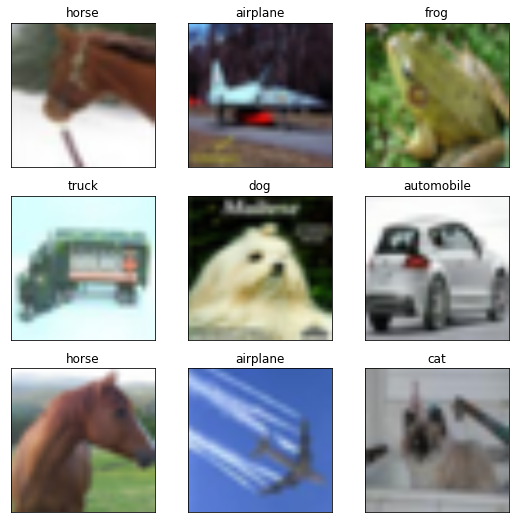

In [ ]:
# Show some imags with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Mostramos imágenes de entrenamiento

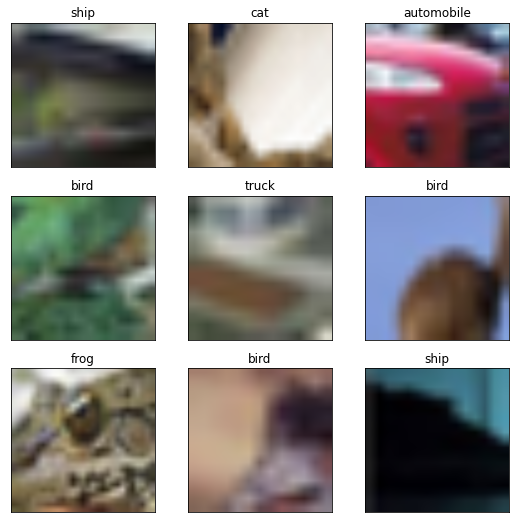

In [ ]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Cargamos el modelo pre-entrenado anteriormente

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [ ]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant


### Evaluamos el modelo

In [ ]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (10,)
params_repl.cls: _ShardedDeviceArray (8, 10)


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

### Precisión del modelo

In [ ]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [ ]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:10<00:00,  3.73s/it]


DeviceArray(0.10063734, dtype=float32)

Aproximadamente se demora 23 minutos en su ejecución sin TPU, con el entorno potenciado se demora aproximadamente 1 minuto

Es un 10.06% de precisión (bastante bajo)

### Ajustamos el modelo

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [ ]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

### Graficamos las pérdidas del modelo

100%|██████████| 100/100 [06:34<00:00,  3.94s/it]


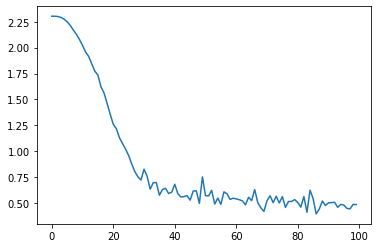

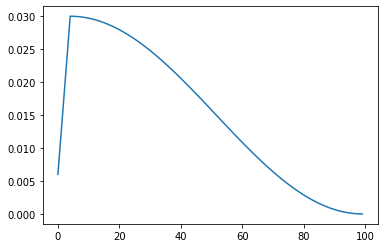

In [ ]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

Aquí se requiere utilizar la aceleración por hardware TPU de todas maneras, ya que, tiene un tiempo de ejecución de aproximadamente 15 minutos, sin TPU tiene un tiempo estimado de 4 horas

### Precisión final

In [ ]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from ~/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:55<00:00,  2.91s/it]


DeviceArray(0.9765625, dtype=float32)

1 minuto de tiempo de ejecución

Obtenemos ahora un 97.65% de precisión, lo cual es bastante bueno

### Inferencia

In [ ]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
/ [1 files][336.9 MiB/336.9 MiB]                                                
Operation completed over 1 objects/336.9 MiB.                                    


### Cargamos modelo pre-entrenado

In [ ]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

### Obtenemos etiquetas

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2022-11-04 23:09:39--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.001s  

2022-11-04 23:09:39 (41.1 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



### Obtenemos una imagen aleatoria con dimensiones específicas

--2022-11-04 23:09:43--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/635/384/384.jpg?hmac=K9nyqJu-s8VOiqRyiMy7kfRG-UWbkLuYGUqA9wVltvo [following]
--2022-11-04 23:09:43--  https://i.picsum.photos/id/635/384/384.jpg?hmac=K9nyqJu-s8VOiqRyiMy7kfRG-UWbkLuYGUqA9wVltvo
Resolving i.picsum.photos (i.picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg              [ <=>                ]  18.39K  --.-KB/s    in 0s      

2022-11-04 23:09:43 (48.0 MB/s) - ‘picsum.jpg’ saved [18828]



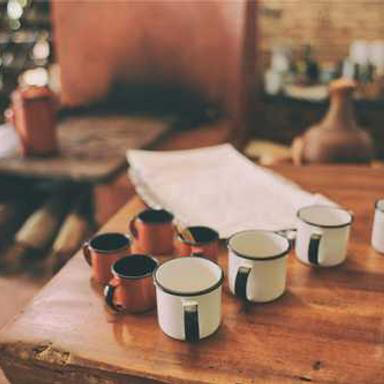

In [ ]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

### Predecimos

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [ ]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.71715 : tray
0.05384 : coffee_mug
0.02169 : dining_table, board
0.02012 : cup
0.01352 : eggnog
0.01116 : restaurant, eating_house, eating_place, eatery
0.00952 : coffeepot
0.00939 : espresso
0.00925 : whiskey_jug
0.00683 : potter's_wheel
